In [470]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, SCORERS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso

In [471]:
data = pd.read_csv('csv_files/snowflake_data.csv')
data.rename(columns={'target': 'Next Full Week Streams'}, inplace=True)
data

,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,rn,end_of_week,popularity,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
0,Young Thug,Hercules,100070,2024-06-13,2016-02-05,15999,101589.0,3051,6,1,True,47,15999,15412.0,15053.0,13938.0,12305.0,14530.0,16076.0,100850
1,Young Thug,Hercules,100070,2024-06-06,2016-02-05,15357,100364.0,3044,6,1,True,47,15357,15191.0,14927.0,14039.0,12311.0,14205.0,15559.0,103313
2,Young Thug,Hercules,100070,2024-05-30,2016-02-05,15457,103225.0,3037,6,1,True,47,15457,15049.0,14144.0,12212.0,12667.0,14507.0,16328.0,101589
3,Young Thug,Hercules,100070,2024-05-23,2016-02-05,15598,103165.0,3030,6,1,True,47,15598,15460.0,15692.0,14715.0,12363.0,13894.0,15503.0,100364
4,Young Thug,Hercules,100070,2024-05-16,2016-02-05,15682,103814.0,3023,6,1,True,47,15682,15269.0,14937.0,14127.0,12459.0,14773.0,15918.0,102812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195561,Don Toliver,New Drop,243502812,2024-06-13,2024-06-13,702,NaN,0,6,1,True,0,702,NaN,NaN,NaN,NaN,NaN,NaN,3726859
195562,Don Toliver,5 To 10,243502816,2024-06-13,2024-06-13,600,NaN,0,6,1,True,0,600,NaN,NaN,NaN,NaN,NaN,NaN,2756571
195563,Don Toliver,Last Laugh,243502819,2024-06-13,2024-06-13,552,NaN,0,6,1,True,0,552,NaN,NaN,NaN,NaN,NaN,NaN,2231508
195564,Don Toliver,Hardstone National Anthem,243502822,2024-06-13,2024-06-13,522,NaN,0,6,1,True,0,522,NaN,NaN,NaN,NaN,NaN,NaN,1757961


## Data Cleansing

First, let's check if we have any duplicates (we shouldn't since the query should handle that). 

In the output below, we can see that there is some weird stuff going on with the 0 values. The number of streams jumps from a very high value to a very low value, and then to 0. For example, row 386 jumps from 51743 streams on day_3, to 5 streams on day_4, to 0 streams on day_5. Thus, we can essentially treat the zeros as null values. This will allow us to perform interpolation on these null values later on.

In [472]:
pd.set_option('display.max_rows', 100)

days = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
keep_cols = ['popularity', 'days_since_release', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'Next Full Week Streams']


duplicates = data[data.duplicated(['unified_song_id', 'date', 'release_date'], keep=False)]
print("Number of duplicates: ", len(duplicates))

dropped = data.drop(columns=['this_week'], axis=1)

# Shows all rows where there is a 0 in any of the columns in 'days'
dropped[(dropped[days] == 0).any(axis=1)][keep_cols].head(100)

Number of duplicates:  0


,popularity,days_since_release,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
88884,23,4766,0,0.0,0.0,0.0,0.0,NaN,NaN,0
191754,9,1,1387,0.0,NaN,NaN,NaN,NaN,NaN,41299
191802,0,7,7,0.0,0.0,0.0,0.0,0.0,0.0,38393
192496,5,1,1679,0.0,NaN,NaN,NaN,NaN,NaN,77159
193042,10,147,2,0.0,0.0,0.0,0.0,0.0,0.0,119728
193043,10,140,0,0.0,0.0,0.0,0.0,NaN,NaN,2
193121,8,147,2,0.0,0.0,0.0,0.0,0.0,0.0,230162
193122,8,140,0,0.0,0.0,0.0,0.0,NaN,NaN,2
193191,52,63,1004,955.0,1012.0,664.0,117.0,0.0,0.0,36473
193192,52,56,0,0.0,0.0,0.0,0.0,NaN,NaN,3752


In [473]:
data = data[keep_cols]


train_valid, test = train_test_split(data, test_size = 0.15, random_state = 42)
train, valid = train_test_split(train_valid, test_size = 0.15, random_state = 42)

In [474]:
train[(train[days] == 0).all(axis=1)]

,popularity,days_since_release,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
195525,49,82,0,0.0,0.0,0.0,0.0,0.0,0.0,33936
193209,60,466,0,0.0,0.0,0.0,0.0,0.0,0.0,88577
195565,76,34,0,0.0,0.0,0.0,0.0,0.0,0.0,39893
195314,46,50,0,0.0,0.0,0.0,0.0,0.0,0.0,15246
195428,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,20416


Let's really try to pick apart the data in each of these columns. If we take a closer look at the 'popularity' column, we see that there are tons of songs that have a popularity score of 0, despite having streaming trends that would indicate a higher popularity score. For example, row item 110357 got over 70,000 streams on most days, but has a popularity score of 0. Let's fix this by replacing all of the zeros with the mean of the 'popularity' column.

In [475]:
def fill_vals(data, cols, is_train=True):
    copy = data.copy()
    
    # Replace all zeros with nulls
    copy[cols] = copy[cols].replace(0, np.nan)
        
    # Interpolate missing values based on previous values
    copy[days] = copy[days].interpolate(method='linear', axis=1)
    
    # Backwards fill missing values that have no previous values (this happens if day_0 has a missing value)
    copy[days] = copy[days].interpolate(method='bfill', axis=1)
    
    # Replace the remaining null values with ones so that we can apply log transofrmations later
    # This will effectively replace ones into the rows that were previously filled with zeros
    copy[cols] = copy[cols].replace(np.nan, 1)
    copy['Next Full Week Streams'] = copy['Next Full Week Streams'].replace(0, 1)
    
    # Replace popularity scores of 0 with the mean
    pop_mean = np.mean(copy['popularity'])
    copy['popularity'] = copy['popularity'].replace(0, pop_mean)

    return copy

temp = train.copy()
print("Before imputing the popularity mean:")
print(temp.loc[110357]) 
print("\n")
train = fill_vals(train, days)
print("After imputing the popularity mean :")
print(train.loc[110357])

Before imputing the popularity mean:
popularity                     0.0
days_since_release          1360.0
day_0                      72745.0
day_1                      71298.0
day_2                      70676.0
day_3                      70345.0
day_4                      59340.0
day_5                      63339.0
day_6                      74190.0
Next Full Week Streams    468008.0
Name: 110357, dtype: float64


After imputing the popularity mean :
popularity                    27.81819
days_since_release          1360.00000
day_0                      72745.00000
day_1                      71298.00000
day_2                      70676.00000
day_3                      70345.00000
day_4                      59340.00000
day_5                      63339.00000
day_6                      74190.00000
Next Full Week Streams    468008.00000
Name: 110357, dtype: float64


In [476]:
def log_transform(data, *cols):
    copy = data.copy()
    for col in cols:
        if col == 'days_since_release':
            copy['days_since_release'] = np.ones(len(copy)) + copy['days_since_release']
        copy[col] = np.log(copy[col])
        copy.rename(columns={col: "log " + col}, inplace=True)
    return copy[[c for c in copy if c != 'log Next Full Week Streams'] + ['log Next Full Week Streams']]


In [477]:
def add_pct_change(data):
    data.loc[:, '1_day_%_change'] = ((data['day_0'] - data['day_1']) / data['day_1']) * 100
    data.loc[:, '3_day_%_change'] = ((data['day_0'] - data['day_3']) / data['day_3']) * 100
    data.loc[:, '6_day_%_change'] = ((data['day_0'] - data['day_6']) / data['day_6']) * 100

add_pct_change(train)

## Exploratory Data Analysis (EDA) and Feature Engineering

Now, let's look at the distributions of each of our features. We can see that the distributions for the target, days_since_release, and each of the day_N columns are very skewed right (Note: only the day_0 distribution is included, though the remaining day_N columns follow a similar distribution). 

Since these features have irregular distributions, we can use feature engineering to help normalize the distributions. Namely, log transformations will be our friend. Let's see if there are any other features that will help improve our model.

<Figure size 640x480 with 0 Axes>

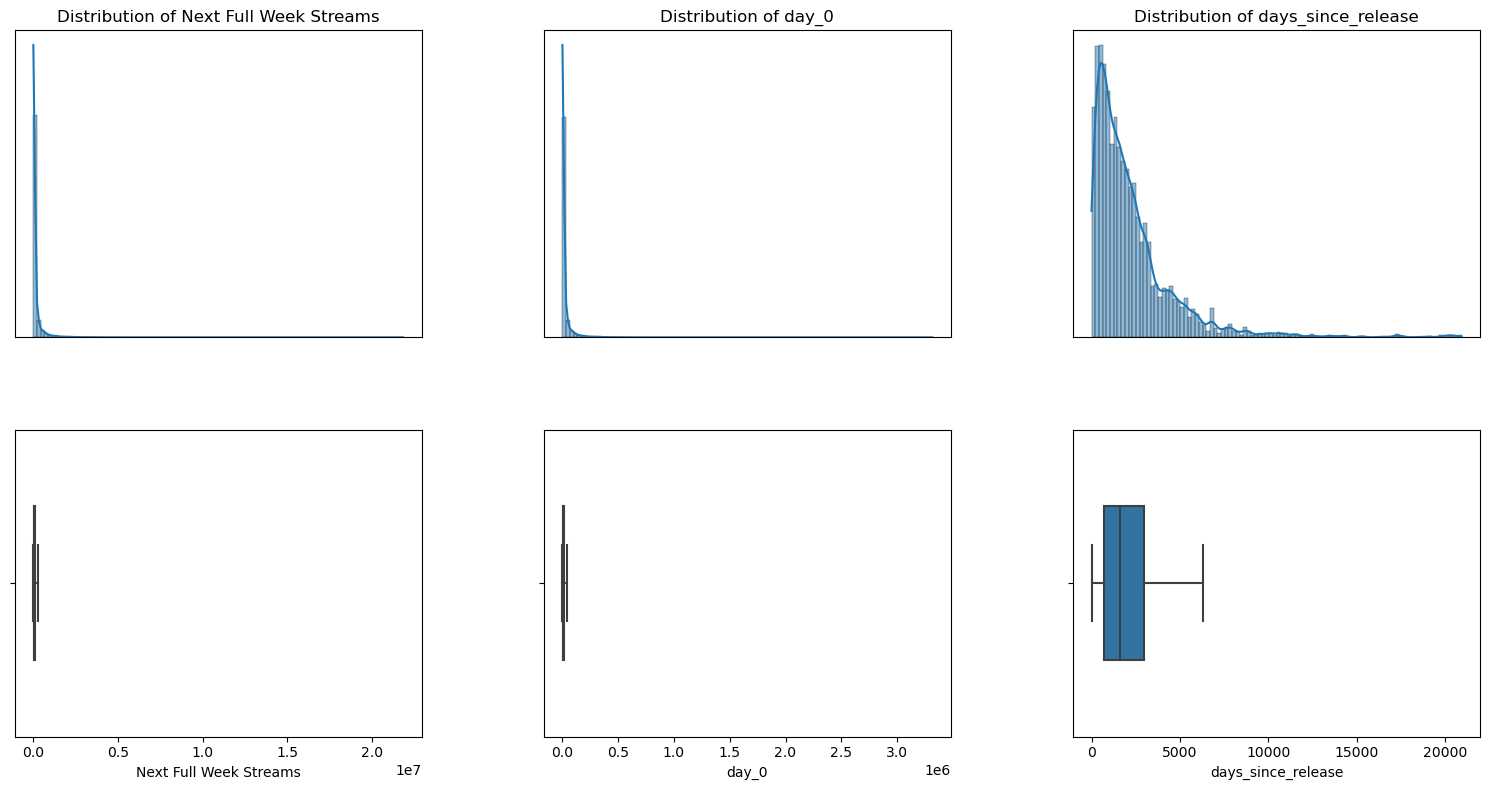

In [478]:
def plot_distribution(data, *labels):
    num_cols = len(labels)
    fig, axs = plt.subplots(nrows=2, ncols=num_cols, figsize=(15, 8))  # Adjust figsize as needed

    for idx, label in enumerate(labels):
        # Plot histogram using sns.histplot
        sns.histplot(data=data[label], kde=True, ax=axs[0, idx], bins=100)
        axs[0, idx].set_title('Distribution of ' + label)
        axs[0, idx].set_xlabel(label)
        axs[0, idx].set_ylabel('Density')

        # Plot boxplot using sns.boxplot
        sns.boxplot(x=data[label], ax=axs[1, idx], width=0.5, showfliers=False)
        axs[1, idx].set_xlabel(label)
        axs[1, idx].set_ylabel('')

        # Adjust xlim for better visualization
        spacer = np.ptp(data[label]) * 0.05  # 5% of the peak-to-peak range
        xmin = np.min(data[label]) - spacer
        xmax = np.max(data[label]) + spacer
        axs[0, idx].set_xlim(xmin, xmax)
        axs[1, idx].set_xlim(xmin, xmax)

        # Remove some axis text
        axs[0, idx].xaxis.set_visible(False)
        axs[0, idx].yaxis.set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.show()
    
plot_distribution(train, 'Next Full Week Streams', 'day_0', 'days_since_release')
plt.show()
plt.tight_layout()

In [479]:
train_log = log_transform(train, 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'Next Full Week Streams')
train_log

,popularity,log days_since_release,log day_0,log day_1,log day_2,log day_3,log day_4,log day_5,log day_6,1_day_%_change,3_day_%_change,6_day_%_change,log Next Full Week Streams
29677,37.00000,8.174985,7.358194,7.390799,7.343426,7.366445,7.252762,7.328437,7.325808,-3.207896,-0.821745,3.291639,9.279773
121533,36.00000,6.302619,8.868976,8.867287,8.849371,8.822617,8.620291,8.722580,8.883363,0.169109,4.745063,-1.428373,10.717856
36301,54.00000,7.960324,12.048688,12.035984,12.078682,12.082141,11.871851,11.997183,12.082254,1.278465,-3.289980,-3.300926,13.931452
80203,17.00000,7.533694,9.392412,9.291275,9.297802,9.285633,9.047351,9.244065,9.401043,10.642811,11.268781,-0.859433,11.198406
138212,36.00000,6.658011,7.908755,7.926603,8.029759,8.053887,7.981392,7.863651,7.845808,-1.768953,-13.509218,6.497065,9.842038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48573,43.00000,7.682943,10.159834,10.144903,10.061303,10.061303,10.061303,10.061303,10.061303,1.504261,10.354840,10.354840,12.045716
128914,41.00000,6.915723,9.506660,9.503458,9.495970,9.440976,9.399389,9.578726,9.578450,0.320752,6.788947,-6.927336,11.383944
82581,27.81819,7.544332,8.879055,8.873048,8.869258,8.854665,8.673000,8.718009,8.849227,0.602494,2.468960,3.027694,10.783488
5849,10.00000,8.030410,8.879890,8.811354,8.779096,8.737773,8.708640,9.010669,9.025335,7.093890,15.271094,-13.536277,10.797165


<Figure size 640x480 with 0 Axes>

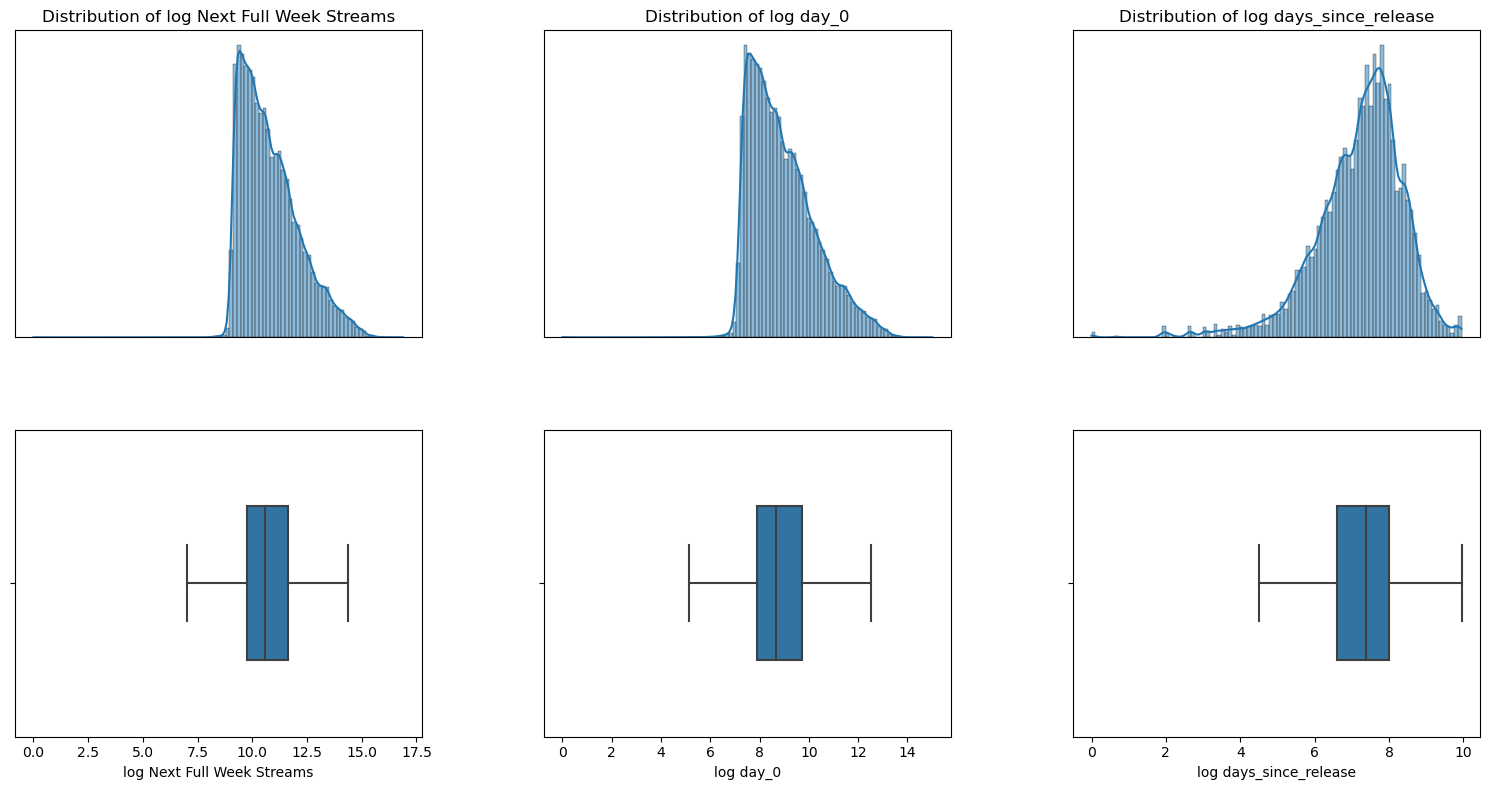

In [480]:
plot_distribution(train_log, 'log Next Full Week Streams', 'log day_0', 'log days_since_release')
plt.show()
plt.tight_layout()

#### So much better!

In [488]:
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        elif keyword_arguments and arguments:
            data = data.pipe(function, *arguments, **keyword_arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [489]:
# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
train_pipelines = [
    (fill_vals, days, {
        'is_train': True
    }),
    (log_transform, 
         ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'target'], 
         None
    ),
    (add_pct_change, None, None)
]

valid_pipelines = [
    (fill_vals, days, {
        'is_train': False
    }),
    (log_transform, 
         ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'target'], 
         None
    ),
    (add_pct_change, None, None)
]

X_train, Y_train = feature_engine_pipe(train, train_pipelines, 'Log Next Full Week Streams')
X_valid, Y_valid = feature_engine_pipe(valid, valid_pipelines, 'Log Next Full Week Streams')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train.head())
display(Y_train.head())

TypeError: fill_vals() got multiple values for argument 'is_train'